# Antiderivatives with Chebyshev

Just like we can find $\frac{d}{dx}y(\theta) = \frac{d}{d\theta} y(\theta) \cdot \frac{d\theta}{dx}$ via chain rule, we should be able to find the antiderivative with the opposite of the chain rule, which is $u$ substitution.

$$ \int f(g(x)) g'(x) dx = \int f(u) du$$

If we introduce a middle layer based on the relationship between $x$ and $\theta$, then say $\theta(x) = \cos^{-1}(x)$ is our "$g(x)$" and $\theta$ is our $u$, then we can evaluate:

$$ \int y(x) dx = \int y(\theta(x)) dx = \int \underbrace{\frac{y(\theta(x))}{\frac{d\theta}{dx}}}_{f(g(x))} \underbrace{\frac{d\theta}{\cancel{dx}}}_{g'(x)} \cancel{dx} = \int \big( \underbrace{y(\theta) \cdot \frac{dx}{d\theta}}_{f(u)} \big) d\theta$$

We know $\frac{dx}{d\theta} = \frac{d}{d\theta} \cos(\theta) = -\sin(\theta)$, so to get the numerical antiderivative, we evaluate the integral

$$ \int \underbrace{-y(\theta) \sin(\theta)}_{\tilde{y}(\theta)} d\theta $$

And we know we can take the numerical antiderivative in the Fourier domain like this by dividing by `jk`.

This is best demonstrated in code:

In [14]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv
import numpy as np
from matplotlib import pyplot
from warnings import warn, catch_warnings, simplefilter

In [15]:
N = 20
x_n = np.cos(np.arange(N+1) * np.pi / N) # length N+1, in keeping with the usage of N in Trefethen.
x = np.linspace(-1, 1, 100) # A denser set of points over the domain, for plotting

In [37]:
def cheb_int(y_n):
	# y_n has to be sampled at cosine-spaced points from [1, -1], because I'm not taking t_n nor scaling
	N = len(y_n) - 1
	M = 2*N # M is always even

	# k = [0, 1, ... M/2 - 1, 0 or M/2, -M/2 + 1, ... -1]
	k = np.concatenate((np.arange(M//2 + 1), np.arange(-M//2 + 1, 0)))
	k[M//2] = 0 # 1st derivative, so Nyquist term is zeroed to be proper
	#k[np.where(k==0)] = 1e-6 # to avoid dividing by zero

	# I'm using the FFT for now, so y needs to be made into y_long with redundant info
	y_n = np.concatenate((y_n, y_n[-2:0:-1])) # We could use the DCT to get in to frequency domain without redundancy!

	# I need to multiply by -sin(th), so we'll need the cosine-spaced theta
	th_n = np.pi * np.arange(N+1) / N
	th_n = np.concatenate((th_n, -th_n[-2:0:-1])) # Using FFT, so need the negative frequencies stacked in!

	y_tilde = -y_n*np.sin(th_n) # the thing we need to integrate to get the right thing in cheb space
	# print(y_tilde) # This is an odd function!
    
	Y_tilde_k = np.fft.fft(y_tilde)
	with catch_warnings(): simplefilter("ignore", category=RuntimeWarning); Y_tilde_nu = (1j * k)**-1 * Y_tilde_k
	Y_tilde_nu[np.where(k==0)] = 0 # Y_tilde_nu is even after multiplication with k! So could use DCT to get back out!

	iy_n = np.fft.ifft(Y_tilde_nu)
	# print(iy_n) # Always even
	return iy_n[:N+1].real # FFT result has redundant info in it, so truncate

mean iy_n -0.007520096393034718
mean iy 0.04580123098784975
L2 1.0030798713745064e-20


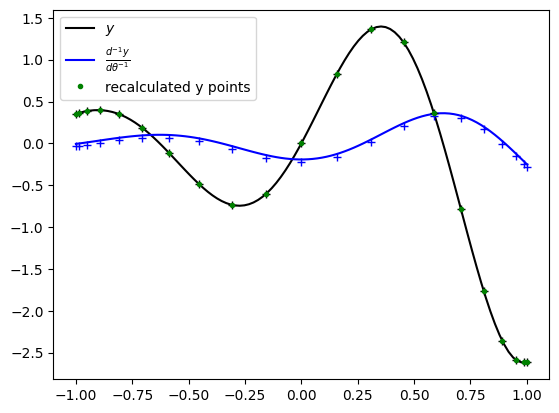

In [38]:
y = np.exp(x) * np.sin(5*x)
iy = np.exp(x)*(np.sin(5*x) - 5*np.cos(5*x))/26 # analytic truth

pyplot.plot(x, y, 'k', label=r'$y$')
pyplot.plot(x, iy, 'b', label=r'$\frac{d^{-1}y}{d\theta^{-1}}$')

y_n = np.exp(x_n) * np.sin(5*x_n)
iy_n = cheb_int(y_n)
print("mean iy_n", np.mean(iy_n))
print("mean iy", np.mean(iy))
y_n_recalc = cheb_deriv(iy_n, x_n, 1)
print("L2", np.mean(y_n - y_n_recalc)**2)

pyplot.plot(x_n, y_n, 'k+')
pyplot.plot(x_n, iy_n, 'b+')
pyplot.plot(x_n, y_n_recalc, 'g.', label="recalculated y points")

pyplot.legend();

Wonderful! So the derivative of the antiderivative is the very same function again. But the numerical antiderivative and analytical indefinite integral are off by a constant factor, which is fine, actually what we expect.

### Below I'm just playing

In [72]:
def cheb_int2(y_n):
	# y_n has to be sampled at cosine-spaced points from [1, -1], because I'm not taking t_n nor scaling
	N = len(y_n) - 1
	M = 2*N # M is always even

	# k = [0, 1, ... M/2 - 1, 0 or M/2, -M/2 + 1, ... -1]
	k = np.concatenate((np.arange(M//2 + 1), np.arange(-M//2 + 1, 0)))
	k[M//2] = 0 # 1st derivative, so Nyquist term is zeroed to be proper
	#k[np.where(k==0)] = 1e-6 # to avoid dividing by zero

	# I'm using the FFT for now, so y needs to be made into y_long with redundant info
	y_n = np.concatenate((y_n, y_n[-2:0:-1])) # We could use the DCT to get in to frequency domain without redundancy!

	# I need to multiply by -sin(th), so we'll need the cosine-spaced theta
	th_n = np.pi * np.arange(N+1) / N
	th_n = np.concatenate((th_n, -th_n[-2:0:-1])) # Using FFT, so need the negative frequencies stacked in!

	#factor = -np.sin(th_n)
	factor = -(np.sin(th_n)**3)/np.cos(th_n)
	#factor[np.where(k==0)] = 0
	#print("factor", factor)

	y_tilde = y_n*factor # the thing we need to integrate to get the right thing in cheb space
	# print(y_tilde) # This is an odd function!
    
	Y_tilde_k = np.fft.fft(y_tilde)
	#print("Y_tilde_k", Y_tilde_k)
	with catch_warnings(): simplefilter("ignore", category=RuntimeWarning); Y_tilde_nu = (1j * k)**(-2) * Y_tilde_k
	Y_tilde_nu[np.where(k==0)] = 0 # Y_tilde_nu is even after multiplication with k! So could use DCT to get back out!
	#print("Y_tilde_nu", Y_tilde_nu)
    
	iy_n = np.fft.ifft(Y_tilde_nu)
	# print(iy_n) # Always even
	return iy_n[:N+1].real # FFT result has redundant info in it, so truncate

mean iy_n -0.007520096393034718
mean iy 0.04580123098784975
L2 1.0030798713745064e-20


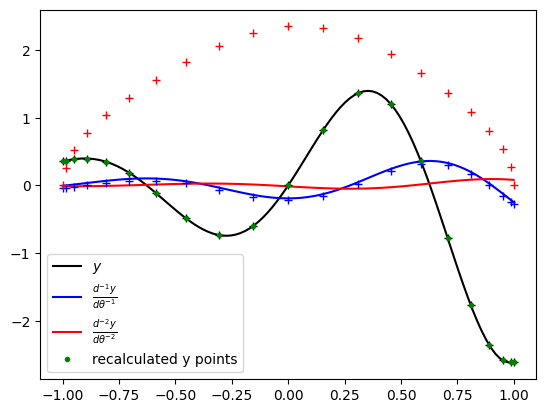

In [73]:
y = np.exp(x) * np.sin(5*x)
iy = np.exp(x)*(np.sin(5*x) - 5*np.cos(5*x))/26 # analytic truth
i2y = -np.exp(x) * (5 * np.cos(5*x) + 12 * np.sin(5*x))/338 

pyplot.plot(x, y, 'k', label=r'$y$')
pyplot.plot(x, iy, 'b', label=r'$\frac{d^{-1}y}{d\theta^{-1}}$')
pyplot.plot(x, i2y, 'r', label=r'$\frac{d^{-2}y}{d\theta^{-2}}$')

y_n = np.exp(x_n) * np.sin(5*x_n)
iy_n = cheb_int(y_n)
i2y_n = cheb_int2(y_n)
print("mean iy_n", np.mean(iy_n))
print("mean iy", np.mean(iy))
y_n_recalc1 = cheb_deriv(iy_n, x_n, 1)
#y_n_recalc2 = cheb_deriv(i2y_n, x_n, 2)
#y_n_recalc2[0:4] = 0
#y_n_recalc2[-4:] = 0
print("L2", np.mean(y_n - y_n_recalc)**2)

#print("y_n_recalc2", y_n_recalc2)

pyplot.plot(x_n, y_n, 'k+')
pyplot.plot(x_n, iy_n, 'b+')
pyplot.plot(x_n, i2y_n, 'r+')
pyplot.plot(x_n, y_n_recalc1, 'g.', label="recalculated y points")
#pyplot.plot(x_n, y_n_recalc2, 'm.', label="recalculated y points")

pyplot.legend();

/usr/local/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.13/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/usr/local/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


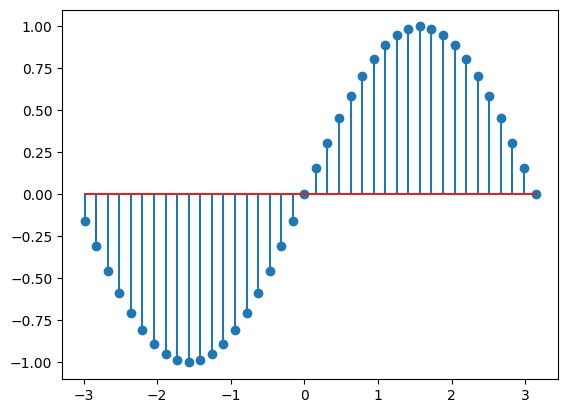

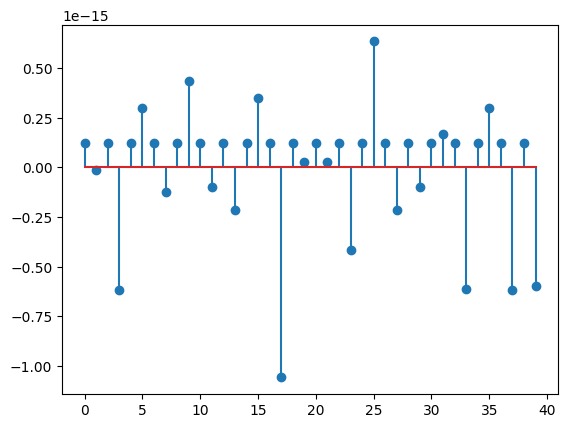

In [60]:
th_n = np.pi * np.arange(N+1) / N
th_n = np.concatenate((th_n, -th_n[-2:0:-1]))
y_n = np.sin(th_n)

pyplot.stem(th_n, y_n)

Y_k = np.fft.fft(y_n)

pyplot.figure()
pyplot.stem(Y_k);
